stores 20, 21, 22, 29, 36, 42, 52, 53 - opened later
last zero sales day:
20 - 2015-02-12
21 - 2015-07-23
22 - 2015-10-08
29 - 2015-03-19
36 - 2013-05-08
42 - 2015-08-20
52 - 2017-04-19
53 - 2015-05-28


In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_log_error, r2_score
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import ScalarFormatter #to change scientific format
import datetime

# Functions
def format_y_axis():    
    ax = plt.gca()
    y_format = ScalarFormatter()
    y_format.set_scientific(False)
    ax.yaxis.set_major_formatter(y_format)
    
def format_y_axis_subplot(ax):    
    y_format = ScalarFormatter()
    y_format.set_scientific(False)
    ax.yaxis.set_major_formatter(y_format)


In [32]:
train_df = pd.read_csv('train.csv', parse_dates=['date'])
train_df.sort_values(by = ['store_nbr', 'family'], inplace = True)

# dropping days with zero sales (the ones zero from 2013-01-01) - store opened later
train_df.drop(index = train_df[(train_df['store_nbr'] == 20) & (train_df['date'] < '2015-02-13')].index, inplace = True)
train_df.drop(index = train_df[(train_df['store_nbr'] == 21) & (train_df['date'] < '2015-07-24')].index, inplace = True)
train_df.drop(index = train_df[(train_df['store_nbr'] == 22) & (train_df['date'] < '2015-10-09')].index, inplace = True)
train_df.drop(index = train_df[(train_df['store_nbr'] == 29) & (train_df['date'] < '2015-03-20')].index, inplace = True)
train_df.drop(index = train_df[(train_df['store_nbr'] == 36) & (train_df['date'] < '2013-05-09')].index, inplace = True)
train_df.drop(index = train_df[(train_df['store_nbr'] == 42) & (train_df['date'] < '2015-08-21')].index, inplace = True)
train_df.drop(index = train_df[(train_df['store_nbr'] == 52) & (train_df['date'] < '2017-04-20')].index, inplace = True)
train_df.drop(index = train_df[(train_df['store_nbr'] == 53) & (train_df['date'] < '2015-05-29')].index, inplace = True)


transactions_df = pd.read_csv('transactions.csv', parse_dates=['date'])
transactions_df['month'] = transactions_df['date'].apply(lambda x: str(x.month))
transactions_df['year'] = transactions_df['date'].apply(lambda x: str(x.year))
transactions_df['year_month'] = transactions_df['year'] + '_' + transactions_df['month']

store_df =pd.read_csv('stores.csv')
holiday_df = pd.read_csv('holidays_events.csv', parse_dates= ['date'] )
holiday_df['weekday'] = [n.isoweekday() for n in holiday_df['date']]

oil_df = pd.read_csv('oil.csv', parse_dates= ['date'] )
sample_submission_df = pd.read_csv('sample_submission.csv')

# adding missing oil prices from the next day
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].fillna(method = 'bfill')

train_df['weekday'] = train_df['date'].apply(lambda x: x.isoweekday())
train_df['month'] = train_df['date'].apply(lambda x: str(x.month).zfill(2)) # zero padding to two digits
train_df['year'] = train_df['date'].apply(lambda x: str(x.year))
train_df['year_month'] = train_df['year'] + '_' + train_df['month']

train_df = pd.merge(train_df, oil_df, how='left', on='date' )
train_df = train_df.rename(columns={'dcoilwtico':'oil_price' })
train_df['oil_price'] = train_df['oil_price'].fillna(method = 'bfill') # some date from the oil_df are missing

train_df = pd.merge(train_df, transactions_df[['date', 'store_nbr', 'transactions']], how='left', on=['date','store_nbr'] )
train_df['transactions'] = np.where(train_df['transactions'].isna() & train_df['sales'] == 0, 0 , train_df['transactions'])
train_df.dropna(subset = 'transactions', inplace = True)

train_df = pd.merge(train_df, store_df, how = 'left', on = 'store_nbr')

prod_list = list(train_df.family.unique())
store_list = list(store_df.store_nbr.unique())

In [33]:
## adding features
# adding time

complete_date_range = pd.DataFrame()
complete_date_range['date'] = pd.date_range(start=train_df['date'].min(), end=test_df['date'].max(),freq='D')
complete_date_range['time'] = complete_date_range.index
train_df = pd.merge(train_df, complete_date_range, how = 'left', on ='date')

train_df['square'] = [n**2 for n in train_df['time']]

def lag(feature, length):
    final_series = pd.Series()
    for f in train_df[ 'family' ].unique():
        filtered = train_df.loc[train_df[ 'family' ] == f]
        for nr in train_df[ 'store_nbr' ].unique():
            filtered2 = filtered.loc[train_df[ 'store_nbr' ] == nr]
            lagged_series = filtered2[ feature ].shift(length)  
            final_series = pd.concat([final_series, lagged_series])
    train_df[f'lag_{feature}_{length}'] = final_series

lag('sales', 1)
lag('sales', 7)
lag('sales', 14)
lag('transactions', 1)
lag('transactions', 7)
lag('transactions', 14)
lag_with_na = [n for n in train_df.columns if n.startswith('lag')]
train_df.dropna(subset= lag_with_na, inplace= True)

# adding days
def add_days(database):
    database['weekday'] = [n.isoweekday() for n in database['date']]
    database = pd.get_dummies(database, columns=['weekday'])
    return database
train_df = add_days(train_df)

train_df['August'] = np.where(train_df['month'] == '08', True, False)

In [34]:
local = holiday_df[ (holiday_df['locale'] == 'Local')&(holiday_df['transferred'] == False)]
local = local.rename(columns = {'locale_name' : 'city' })
regional = holiday_df[ (holiday_df['locale'] == 'Regional')&(holiday_df['transferred'] == False)]
regional = regional.rename(columns = {'locale_name' : 'state' })
national = holiday_df[ (holiday_df['locale'] == 'National')&(holiday_df['transferred'] == False)]


In [35]:
# adding holidays national, regional, local in 3 different columns
train_df = pd.merge(train_df, national[['date', 'transferred']], on = 'date', how = 'left')
train_df = train_df.rename( columns={ 'transferred' : 'holiday'})
train_df['holiday'] = np.where(train_df['holiday'] == False, True, False)

train_df = pd.merge(train_df, regional[['date', 'state', 'transferred']], on = ['date', 'state'], how = 'left')
train_df = train_df.rename( columns={ 'transferred' : 'holiday_reg'})
train_df['holiday_reg'] = np.where(train_df['holiday_reg'] == False, True, False)

train_df = pd.merge(train_df, local[['date', 'city', 'transferred']], on = ['date', 'city'], how = 'left')
train_df = train_df.rename( columns={ 'transferred' : 'holiday_loc'})
train_df['holiday_loc'] = np.where(train_df['holiday_loc'] == False, True, False)

In [37]:
train_df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'month',
       'year', 'year_month', 'oil_price', 'transactions', 'city', 'state',
       'type', 'cluster', 'time', 'square', 'lag_sales_1', 'lag_sales_7',
       'lag_sales_14', 'lag_transactions_1', 'lag_transactions_7',
       'lag_transactions_14', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7', 'August', 'holiday',
       'holiday_reg', 'holiday_loc'],
      dtype='object')

In [3]:
train_df = pd.read_csv('train.csv')

In [21]:
store_df =pd.read_csv('stores.csv')
prod_list = list(train_df.family.unique())
store_list = list(store_df.store_nbr.unique())

In [49]:
# taking out from Sat and Sun from holidays
train_df['holiday'] = np.where((train_df['weekday_6'] == True) | (train_df['weekday_7'] == True), False, train_df['holiday'] ) 
train_df['holiday_loc'] = np.where((train_df['weekday_6'] == True) | (train_df['weekday_7'] == True), False, train_df['holiday_loc'] ) 
train_df['holiday_reg'] = np.where((train_df['weekday_6'] == True) | (train_df['weekday_7'] == True), False, train_df['holiday_reg'] ) 

In [19]:
# adding saturdays and sundays after friday holiday
holiday_fri = train_df[(train_df['weekday_5'] == True) & (train_df['holiday'] == True)]
tdelta = datetime.timedelta(days = 1)
holiday_fri_sat = [n+tdelta for n in holiday_fri.date.unique()]
holiday_fri_sun = [n+2*tdelta for n in holiday_fri.date.unique()]
train_df['holiday_fri_sat'] = train_df['date'].isin(holiday_fri_sat)
train_df['holiday_fri_sun'] = train_df['date'].isin(holiday_fri_sun)

In [23]:
df_CV= train_df[('2016-07-31' < train_df['date']) & (train_df['date'] < '2016-09-01')]
df_test = train_df[('2017-07-31' < train_df['date']) & (train_df['date'] < '2017-08-16')]
df_test.sort_values(by = ['store_nbr', 'family'], inplace = True)
df_train = train_df[(train_df['date'] < '2017-08-01')]


In [14]:
def run_rgr_all(*args, scale = 'yes'):
    #  preparing_data sets
    arg_list = list(args)
    y_CV_acc = np.empty((0,1))
    X_CV_acc = np.empty((0,len(args)))
    pred_CV_acc = np.empty((0,1))

    for nr in store_list:
        filtered = df_train.loc[df_train['store_nbr'] == nr]
        for f in prod_list:
            filtered2 = filtered.loc[df_train[ 'family' ] == f]
     
            X_CV = filtered2.loc[(('2016-07-31' < filtered2['date']) & (filtered2['date'] < '2016-09-01')), arg_list]
            if X_CV.shape ==  (0, len(args)):
                continue

            CV_index_dropped = filtered2.drop(index = X_CV.index)
            X_train = CV_index_dropped[arg_list].values
            y_train = CV_index_dropped['sales'].values.reshape(-1, 1)
            
            X_CV = X_CV.values
            y_CV = filtered2.loc[(('2016-07-31' < filtered2['date']) & (filtered2['date'] < '2016-09-01')), ['sales']].values.reshape(-1, 1)        
            
            if scale == 'yes':
                scaler = StandardScaler()
                scaler.fit(X_train)
                X_train = scaler.transform(X_train)
                X_CV  = scaler.transform(X_CV)

            rgr = linear_model.LinearRegression()
            rgr.fit(X_train, y_train)
            pred_CV = rgr.predict(X_CV)

            y_CV_acc = np.concatenate((y_CV_acc, y_CV)).reshape(-1, 1)
            pred_CV_acc = np.concatenate((pred_CV_acc, pred_CV)).reshape(-1, 1)     

    # not allowing negative amounts in the prediction
    pred_CV_acc[pred_CV_acc < 0] = 0

    return pred_CV_acc
   
 

In [30]:
train_df.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')

In [16]:
x = run_rgr_all('time', 'lag_sales_1', 'lag_sales_7', 'lag_sales_14', 'lag_transactions_1', 'lag_transactions_7',
       'lag_transactions_14', 'onpromotion', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 
       'weekday_6', 'weekday_7', 'holiday', scale = 'yes', output = 'pred')

In [4]:
df = pd.read_csv('df_CV_2.csv')

In [5]:
df.columns

Index(['Unnamed: 0.6', 'Unnamed: 0.5', 'Unnamed: 0.4', 'Unnamed: 0.3',
       'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'id', 'date', 'store_nbr',
       'family', 'sales', 'onpromotion', 'month', 'year', 'year_month',
       'oil_price', 'transactions', 'city', 'state', 'type', 'cluster', 'time',
       'square', 'lag1', 'lag7', 'lag14', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7',
       'pred_2', 'pred_3', 'pred_4', 'pred_5', 'pred_6', 'pred_7', 'pred_8',
       'pred_9', 'pred_10'],
      dtype='object')

In [64]:
MSLE = mean_squared_log_error(df['sales'], df['pred_11'])
np.sqrt(MSLE)

0.5886374460812439

In [7]:
MSLE = mean_squared_log_error(df['sales'], df['pred_3'])
np.sqrt(MSLE)

0.5848291609433294

In [61]:
zero_check = train_df[('2016-07-24'< train_df['date']) & (train_df['date'] < '2016-08-01')]
zero_check = zero_check.groupby(by = ['store_nbr', 'family'])['sales'].sum().reset_index()
zero_check = zero_check[(zero_check['sales'] == 0) & (zero_check['family'] != 'SCHOOL AND OFFICE SUPPLIES') &  (zero_check['family'] != 'BABY CARE')]

In [62]:
zero_check.family.value_counts()

family
BOOKS              53
HOME APPLIANCES    40
LAWN AND GARDEN    15
LADIESWEAR         13
GROCERY II          7
MAGAZINES           2
PET SUPPLIES        1
SEAFOOD             1
Name: count, dtype: int64

In [63]:
zero_check.rename(columns = {'sales' : 'zero_pred'}, inplace = True)
df = pd.merge(df, zero_check, on = ['store_nbr', 'family'], how = 'left')
df['pred_11'] = df['pred_3']
df['pred_11'] = np.where(df['zero_pred'] == 0, 0, df['pred_11'])
df.drop(columns = ['zero_pred'], inplace = True)

In [12]:
def error_list(group1, group2, pred = 'pred_3'):    
    CV_grouped = df.groupby(by =[group1 , group2])[['sales', pred]].sum()
    list =[]
    for item in df[group1].unique():
        filtered = CV_grouped.loc[item]
        MSLE = mean_squared_log_error(filtered['sales'], filtered[pred])
        RMSLE = np.sqrt(MSLE)
        list.append(RMSLE)
    df2 = pd.DataFrame()
    df2[group1] = df[group1].unique()
    df2['RMSLE'] = list
    df2.sort_values(by = 'RMSLE', ascending = False, inplace = True)
    return df2

In [13]:
pred_3 = error_list('store_nbr', 'family')
pred_4 = error_list('store_nbr', 'family', pred = 'pred_4')

pred_comp = pd.merge(pred_3, pred_4, on ='store_nbr', how = 'left')


In [14]:
pred_3 = error_list('store_nbr', 'date')
pred_4 = error_list('store_nbr', 'date', pred = 'pred_4')

pred_comp = pd.merge(pred_3, pred_4, on ='store_nbr', how = 'left')



In [15]:
pred_3 = error_list('family', 'date')
pred_4 = error_list('family', 'date', pred = 'pred_4')

pred_comp = pd.merge(pred_3, pred_4, on ='family', how = 'left')


In [16]:
def create_plot(database, prediction, group, filter):
    CV_grouped = database.groupby(by =[group, 'date'])[['sales', prediction]].sum().loc[filter]
    MSLE = mean_squared_log_error(CV_grouped['sales'], CV_grouped[prediction])
    RMSLE = np.sqrt(MSLE)

    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(CV_grouped.index, CV_grouped['sales'], label = 'actual')
    ax.plot(CV_grouped.index, CV_grouped[prediction], label = 'predicted')
    ax.set_title('CV_plot')
    fig.text(0.15, 0.15, "RMSLE: %.4f" % RMSLE) 
    ax.legend()
    ax.tick_params(axis='x', rotation=90)

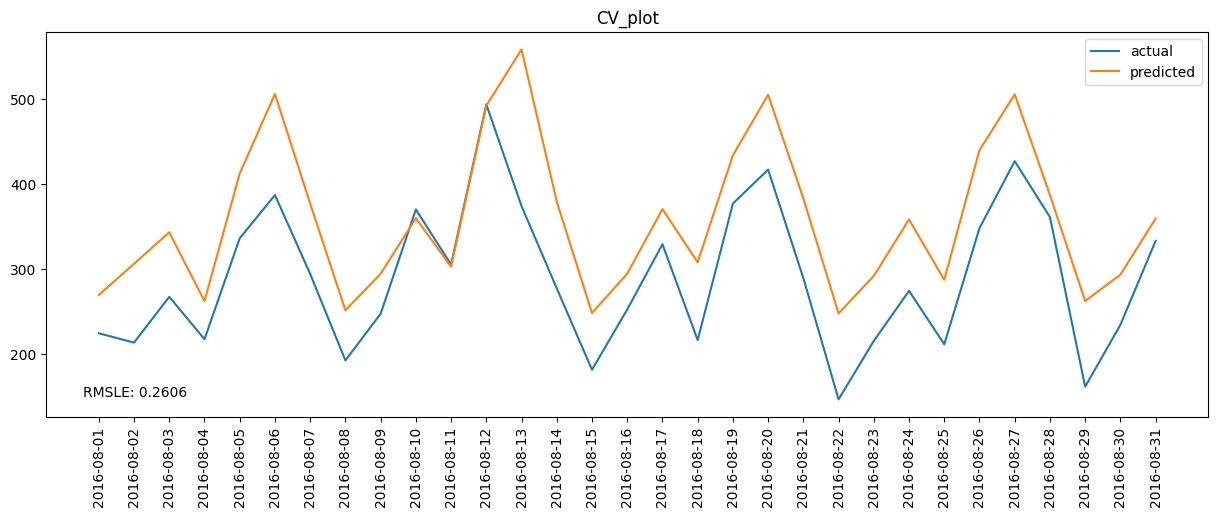

In [17]:
create_plot(df, 'pred_9', 'family', 'LAWN AND GARDEN')

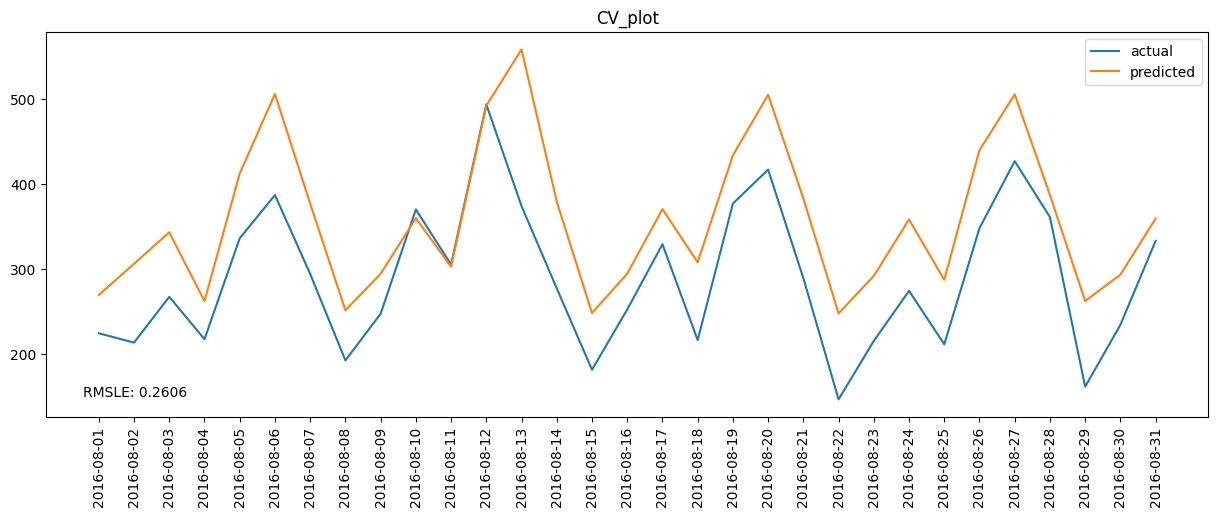

In [18]:
create_plot(df, 'pred_10',  'family', 'LAWN AND GARDEN')

In [27]:
def run_rgr_test(*args, scale = 'yes'):
    #  preparing_data sets
    arg_list = list(args)
    y_CV_acc = np.empty((0,1))
    X_CV_acc = np.empty((0,len(args)))
    pred_CV_acc = np.empty((0,1))

    for nr in store_list:
        filtered = train_df.loc[train_df['store_nbr'] == nr]
        for f in prod_list:
            filtered2 = filtered.loc[train_df[ 'family' ] == f]
     
            X_CV = filtered2.loc[(('2017-07-31' < filtered2['date']) & (filtered2['date'] < '2017-08-16')), arg_list]
            if X_CV.shape ==  (0, len(args)):
                continue

            CV_index_dropped = filtered2.drop(index = X_CV.index)
            X_train = CV_index_dropped[arg_list].values
            y_train = CV_index_dropped['sales'].values.reshape(-1, 1)
            
            X_CV = X_CV.values
            y_CV = filtered2.loc[(('2017-07-31' < filtered2['date']) & (filtered2['date'] < '2017-08-16')), ['sales']].values.reshape(-1, 1)        
            
            if scale == 'yes':
                scaler = StandardScaler()
                scaler.fit(X_train)
                X_train = scaler.transform(X_train)
                X_CV  = scaler.transform(X_CV)

            rgr = linear_model.LinearRegression()
            rgr.fit(X_train, y_train)
            pred_CV = rgr.predict(X_CV)

            y_CV_acc = np.concatenate((y_CV_acc, y_CV)).reshape(-1, 1)
            pred_CV_acc = np.concatenate((pred_CV_acc, pred_CV)).reshape(-1, 1)     

    # not allowing negative amounts in the prediction
    pred_CV_acc[pred_CV_acc < 0] = 0

    return pred_CV_acc

In [39]:
x = run_rgr_test('time', 'lag_sales_1', 'lag_sales_7', 'lag_sales_14',  'onpromotion', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 
             'weekday_5',  'weekday_6', 'weekday_7', 'holiday')

In [44]:

len(df_test)

26730

In [52]:
df_test['pred_1'] = x

In [53]:
df_test.to_csv('df_test.csv')

In [54]:
MSLE = mean_squared_log_error(df_test['sales'], df_test['pred_1'])
np.sqrt(MSLE)

0.4243491603918498

In [68]:
zero_check = df_test[('2017-07-24'< df_test['date']) & (df_test['date'] < '2017-08-01')]
zero_check = zero_check.groupby(by = ['store_nbr', 'family'])['sales'].sum().reset_index()
zero_check = zero_check[(zero_check['sales'] == 0)]
zero_check.family.value_counts()

Series([], Name: count, dtype: int64)